In [ ]:
# What is Reinforcement Learning?
# Similar to how humans learn
#
# Agent performs an action (on the)-> Environment (gives)-> Feedback to the agent (current state + a reward).
# The agent learns to make those actions if it gets a positive reward
# , but not to make them if it gets a negative reward (reinforcement learning).
# After many of these cycles, the agent learns how to optimally act on the environment for each state


# What is Nim?
#   2 player game where players take turns making moves (all impartial games are like this)
#
#   The game starts with an arbitrary number of heaps. Each heap has an arbitrary number of elements
#
#   In one move:
#     a player selects any heap (with a positive number of stones)
#     the player selects any positive number of elements and remove them from the heap
#
# Example of a game of Nim:
#   3 heaps
#   Starting heaps: 10, 2, 1
#
#   The first move: player 1 selects the 1st heap and remove 5 elements
#   Heaps after the first move: 5, 2, 1
#   The second move: player 2 selects the 2nd heap and removes all 2 elements
#   Heaps after the second move: 5, 0, 1
#   The third move: player 1 selects the 1st heap and remove 3 elements
#   Heaps after the third move: 2, 0, 1
#   ...
#   ...
#   1st player makes a move:
#   After that move: 0, 0, 0
#
#   player 1 wins the game and player 2 loses

In [148]:
# random module for generating random games
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pickle
from typing import List

%matplotlib inline
rcParams['figure.figsize'] = (12,6) # set default figure size
rcParams['figure.facecolor'] = 'w'

In [149]:
# make sure the working directory is that of the script since jupyter notebook
# has a different default working directory specified by the config file (I think)

In [150]:
class Agent:
    def action(self, heaps : List[int]) -> tuple:
        """
        **Description:**
          - Returns an action for the state "heaps"

        **Parameter:**
            - heaps: List[int]

              + current state represented by heaps of elements
        """

        heap_chosen = None; elements_to_remove = None
        return heap_chosen, elements_to_remove

In [151]:
class Game:
    def __init__(self, num_heaps: int, max_elements: int) -> None:
        """
        **Description:**
            - Generates a random game of nim (represented by heaps).
              Allows for easy action by action play of the game.

            - Computationally efficient.
              The heaps are maintained in sorted order to reduce the number of states by ~heaps!

        **Parameters:**
            - num_heaps: int

              + number of heaps in initial game

            - max_elements: int

              + maximum number of elements per heap

        **Attributes:**
            - num_heaps: int

              + number of heaps in initial game

            - max_elements: int

              + maximum number of elements per heap

            - heaps: List[int]

              + current state represented by heaps of elements

              + the heaps are maintained in reverse sorted order and all empty heaps are removed (no zeros)

              + maintained in O(self.num_heaps) per operation

            - xor_sum: int

              + xor_sum of self.heaps
        """

        self.num_heaps = num_heaps
        self.max_element = max_elements
        self.heaps = sorted([random.randint(1, max_elements) for i in range(num_heaps)], reverse=True)
        self.xor_sum = 0
        for heap in self.heaps:
            self.xor_sum ^= heap

    def perform_action(self, heap_chosen: int, elements_to_remove: int) -> bool:
        """
        **Description:**
          - Performs action on self.heaps (state).

          - Maintains sorted order of heaps in O(num_heaps).

        **Return:**
             - True if the action was optimal else False
        """

        try:
            prev_xor_sum = self.xor_sum
            self.xor_sum ^= self.heaps[heap_chosen]
            self.heaps[heap_chosen] -= elements_to_remove
            self.xor_sum ^= self.heaps[heap_chosen]

            # maintain sorted order of heaps in O(num_heaps)
            if self.heaps[heap_chosen] == 0:
                self.heaps.pop(heap_chosen)  # remove heap from heaps since it is empty
            else:
                # keep swapping heap_chosen with heap_chosen+1 until heaps is sorted
                while heap_chosen < len(self.heaps) - 1 and self.heaps[heap_chosen] < self.heaps[heap_chosen + 1]:
                    self.heaps[heap_chosen], self.heaps[heap_chosen + 1] = self.heaps[heap_chosen + 1], self.heaps[heap_chosen]
                    heap_chosen += 1

            # see if action was optimal
            # Note that any move is optimal if the xor is zero, but this occurs with
            # low probability (~1/elements because it's expected to be a random number)
            if prev_xor_sum == 0:
                # any action is optimal
                return True
            else:
                if self.xor_sum == 0:
                    return True
                else:
                    return False

        except:
            raise Exception("Invalid Action")

    def finished(self) -> bool:
        """
        **Return:**
            - Returns if the game is finished

              + The game is finished if all heaps are empty
        """

        return len(self.heaps) > 0

    def play_game(self, agent1 : Agent, agent2 : Agent, store_game : bool = False) -> tuple:
        """
        **Parameters:**
            - agent1: Agent

              + agent that moves first

            - agent2: Agent

              + agent that moves second

            - store_game: bool

              + if we store the game or not

        **Return:**
            - 1 if agent 1 won else 0, the full game
        """

        full_game = []

        turn = 0
        while not self.finished():
            if store_game:
                full_game.append(self.heaps.copy())

            turn += 1

            # find action that the current agent moving wants to do
            if turn & 1:
                action = agent1.action(self.heaps)
            else:
                action = agent2.action(self.heaps)
            # perform action
            self.perform_action(*action)
        if store_game:
            full_game.append(self.heaps.copy()) # self.heaps should be an empty list

        # turn is now the total turns in the completed game

        win = turn & 1  # 1 if agent 1 won else 0 if agent 2 won

        return win, full_game

In [152]:
class RandomAgent(Agent):
    def action(self, heaps : List[int]) -> tuple:
        """
        **Description:**
            - Returns a random action for the state "heaps"

        **Parameter:**
            - heaps: List[int]

              + current state represented by heaps of elements
        """

        heap_chosen = random.randint(0, len(heaps) - 1)
        elements_to_remove = random.randint(1, heaps[heap_chosen])

        return heap_chosen, elements_to_remove

In [153]:
class OptimalAgent(Agent):
    def action(self, heaps : List[int]) -> tuple:
        """
        **Description:**
             - Find the optimal action for the state "heaps" via game theory

        **Parameter:**
            - heaps: List[int]

              + current state represented by heaps of elements

        **Logic:**
            If the xor_sum of the heaps is 0:
                Any action is optimal (xor_sum becomes positive).
            Else:
                The optimal action changes the xor_sum to 0, and it always exists.
        """

        xor_sum = 0  # xor sum of elements in heaps
        for elements in heaps:
            xor_sum ^= elements

        if xor_sum == 0:
            # no matter what move the agent does, it will not be optimal
            # thus, the agent can select any move, so we pick a move that takes O(1) to perform
            heap_chosen = len(heaps) - 1
            elements_to_remove = 1
        else:
            max_set_bit = 0  # max set bit in xor_sum
            while 1 << max_set_bit + 1 <= xor_sum:
                max_set_bit += 1

            # find heap with mx_set_bit set, which is guaranteed to exist
            for heap in range(len(heaps)):
                if (heaps[heap] >> max_set_bit) & 1:
                    heap_chosen = heap

            new_elements = xor_sum ^ heaps[heap_chosen]  # guaranteed to be < heaps[heap_chosen]
            elements_to_remove = heaps[heap_chosen] - new_elements

        return heap_chosen, elements_to_remove

In [154]:
def test_optimal_agent(num_games=10**4, max_num_heaps=100, max_elements=100) -> None:
    """Tests the optimal agent by playing 1e4 games with very large heaps (100 x 100).

    The optimal agent is tested against the random agent to ensure there is no logic overlap
    (nothing that we assume is true that we don't test).

    There is a high change the random agent code is correct and even a slight mistake
    should result in the optimal agent's loss.
    Thus, we can be confident there are no errors with the optimal agent if it passes.
    """

    for game_num in range(1, num_games + 1):
        game = Game(max_num_heaps, max_elements)
        win, full_game = game.play_game(OptimalAgent(), RandomAgent(), True)

        # although the xor sum of the intial heaps might not be 0,
        # all the optimal agent needs to win is for the random agent to play
        # a non-optimal move (not make xor sum = 0), which is almost guaranteed for the game size
        # the second agent should lose
        if win == 0:
            print(f"Bad Game:")
            for heaps in full_game:
                print(heaps)

# test_optimal_agent()  # does not print "Bad Game", so all games were won

In [155]:
class QLearningAgent(Agent):
    def __init__(self, obj_dir: str, train_opponent_name : str = None,
                 num_heaps: int = None, max_elements: int = None,
                 alpha: float = None, gamma: float = None, epsilon: float = None) -> None:
        """
        **Description:**
          - Initializes the Q Agent either by loading it from the file if it exists. Otherwise,
            initializes a fresh object and creates necessary directories and files

        **Parameters:**
            - obj_dir: str

              + directory where object data will be saved
                (object itself, csv of accuracy, plots of said csv)

            - train_opponent_name: str

              + name of the opponent used to train the Q agent
                (make "self" for the agent to train by playing itself)

            - num_heaps: int

              + number of heaps in initial game

            - max_elements: int

              + maximum number of elements per heap

            - alpha: float

              + learning rate

            - gamma: float

              + discount factor

            - epsilon: float

              + exploration rate

        **Attributes:**
            - obj_dir: str

              + directory where object data will be saved
                (object itself, csv of accuracy, plots of said csv).

            - train_opponent_name: str

              + name of the opponent used to train the Q agent
                (use self for the agent to train by playing itself).

            - train_opponent: Agent

              + object of some agent class determined by self.train_opponent_name

            - num_heaps: int

              + number of heaps in initial game.

            - max_elements: int

              + maximum number of elements per heap.

            - alpha: float

              + learning rate.

            - gamma: float

              + discount factor.

            - epsilon: float

              + exploration rate.

            - played_games: int

              + total number of games played during training (until last save point).

            - name: str

              + long name that describes Q agent based on parameters.

            - ascii_name: str

              + Same as self.name but using only ascii characters.

            - Q: Dict[tuple, Dict[tuple, float]]

              + Q table storing state-action pairs.
        """

        if not os.path.exists(obj_dir):
            os.mkdir(obj_dir)

        if os.path.isfile(obj_dir + '/obj') and os.path.exists(obj_dir + '/obj'):
            # load it
            with open(obj_dir + '/obj', "rb") as fin:
                obj = pickle.load(fin)
                self.__dict__.update(obj.__dict__)
        else:
            # we haven't created the file yet

            self.obj_dir = obj_dir
            self.train_opponent_name = train_opponent_name
            self.train_opponent = None
            if self.train_opponent_name == 'self':
                self.train_opponent = self
            else:
                exec('self.train_opponent = eval(self.train_opponent_name)()')
            self.num_heaps = num_heaps
            self.max_elements = max_elements
            self.alpha = alpha
            self.gamma = gamma
            self.epsilon = epsilon
            self.played_games = 0
            self.name = f'(Q Agent): train_opponent={self.train_opponent_name},\n' \
                        f'          num_heaps={self.num_heaps}, max_elements={self.max_elements},\n' \
                        f'          α={alpha}, γ={gamma}, ε={epsilon}'
            self.ascii_name = f'(Q Agent) train_opponent={self.train_opponent_name}, '\
                              f'num_heaps={self.num_heaps}, max_elements={self.max_elements}, '\
                              f'alpha={alpha}, gamma={gamma}, epsilon={epsilon}'

            # create new Q table
            self.Q = {}
            for i in range(pow(self.max_elements+1, self.num_heaps)):
                # i represents a state in base max_elements+1
                state = []
                while i:
                    state.append(i % (self.max_elements+1))
                    i //= self.max_elements + 1
                state.sort(reverse=True)
                while state and state[-1] == 0:
                    state.pop()

                if tuple(state) not in self.Q:
                    # add state and actions to Q
                    self.Q[tuple(state)] = {}

                    next_states = set()
                    for heap_chosen in range(len(state)):
                        for elements_to_remove in range(1, state[heap_chosen]+1):
                            game = Game(0, 0); game.heaps = state.copy()
                            game.perform_action(heap_chosen, elements_to_remove)
                            new_state = tuple(game.heaps)

                            if new_state not in next_states:
                                # move leads to unique, new state
                                next_states.add(new_state)
                                self.Q[tuple(state)][(heap_chosen, elements_to_remove)] = 0 # initialize to 0

            # create text file who's name gives information about the agent (since the folder name is probably useless)
            with open(self.obj_dir + '/' + self.ascii_name, 'w') as fin:
                pass

            # create/save accuracy dataframe
            self.accuracy = pd.DataFrame(data=[[self.test_accuracy()]], index=[0], columns=[self.name])
            self.accuracy.index.rename('Games Played', inplace=True)
            if os.path.isfile(self.obj_dir + '/accuracy.csv') and os.path.exists(self.obj_dir + '/accuracy.csv'):
                # load accuracy data from file
                self.accuracy = pd.read_csv(self.obj_dir + '/accuracy.csv')
            else:
                # create accuracy file if it doesn't exist
                self.accuracy.to_csv(self.obj_dir + '/accuracy.csv')

            self.save(self.obj_dir + '/obj') # save entire object

    def update_q(self, s: list, a: tuple, reward: float, sp: list = None) -> None:
        """
        **Description:**
            - Updates the Q table

        **Parameters:**
            - s: list

              + previous state

            - a: tuple

              + action at s

            - reward: float

              + If sp is None, (game is over): should be 1 if Q agent won else -1. Otherwise, 0.

            - sp: list

              + resulting state after opponent makes their move (None if game is over)

        **Return:**
            - None
        """

        s = tuple(s)

        if sp is not None:
            sp = tuple(sp)
            self.Q[s][a] += self.alpha * (reward + self.gamma*max(self.Q[sp].values()) - self.Q[s][a])
        else:
            self.Q[s][a] += self.alpha * (reward - self.Q[s][a])

    def train(self, games: int, save_games: int) -> None:
        """
        **Description:**
            - Make the Q agent play "games" games to train it. Continues building off of previous Q table.
              Thus, new accuracy measurements at each save point are concatenated to self.accuracy.

        **Parameters:**
            - games: int

              + games to play

            - save_games: int

              + save all data every save_games

        **Return:**
            - None
        """

        for game in range(1, games+1):
            # print(self.alpha)
            # self.alpha *= 0.9**(1/1000)

            if game % save_games == 0:
                # save updated object and update + save accuracy
                self.played_games += save_games

                self.accuracy.loc[self.accuracy.index[-1] + save_games] = self.test_accuracy() # new entry
                self.accuracy.to_csv(self.obj_dir + '/accuracy.csv')

                self.save(self.obj_dir + '/obj')

            game = Game(self.num_heaps, self.max_elements)
            turn = 0
            q_agent_last_action = None
            prev_heaps = None # heaps right before q agent's last action
            while not game.finished():
                turn += 1

                # find action that the current agent moving wants to do
                if turn & 1:
                    if random.uniform(0, 1) < self.epsilon:
                        # make random action
                        pos_actions = list(self.Q[tuple(game.heaps)].keys())
                        action = random.choice(pos_actions)
                    else:
                        # perform best move known to agent
                        action = self.action(game.heaps)

                    q_agent_last_action = action # save
                    prev_heaps = game.heaps.copy()

                    game.perform_action(*action)
                else:
                    action = self.train_opponent.action(game.heaps)
                    # perform action
                    game.perform_action(*action)

                    # update Q if game has not ended
                    if game.heaps and q_agent_last_action:
                        self.update_q(prev_heaps, q_agent_last_action, 0, game.heaps)

            # turn is now the total turns in the completed game
            win = turn & 1  # 1 if agent 1 won else 0 if agent 2 won

            # update Q now that game has ended
            if q_agent_last_action:
                reward = 1 if win else -1
                # lost, punish agent for making bad move and propagate expected future returns
                self.update_q(prev_heaps, q_agent_last_action, reward)

    def save(self, obj_file: str) -> None:
        """
        **Description:**
            - Pickles self.Q and saves it at obj_file
        """

        with open(obj_file, 'wb') as fout:
            pickle.dump(self, fout)

    def test_accuracy(self, num_actions: int = 1000) -> None:
        """
        **Description:**
            - Test num_actions on random game states to find percentage of optimal moves
        """

        accuracy = 0
        for action in range(num_actions):
            game = Game(self.num_heaps, self.max_elements)
            accuracy += game.perform_action(*self.action(game.heaps))
        accuracy /= num_actions

        return accuracy

    def plot_accuracy(self, color : str = None) -> None:
        """
        **Description:**
            - Plots self.accuracy.

        **Parameter:**
            - color: str

              + matplotlib color for plot
        """

        Ax = self.accuracy.plot()
        if color:
            Ax.get_lines()[0].set_color(color)
            Ax.get_legend().legendHandles[0].set_color(color)
        plt.xlabel(self.accuracy.index.name, color = "purple")
        plt.ylabel("Percentage of Optimal Moves", color = "purple")

    def save_accuracy_plot(self, color : str = None) -> None:
        """
        **Description:**
            - Plots self.accuracy and saves it.

        **Parameter:**
            - color: str

              + matplotlib color for plot
        """

        self.plot_accuracy(color)
        plt.savefig(self.obj_dir + f'/{self.played_games} games.png')

    def action(self, heaps : List[int]) -> tuple:
        """
        **Description:**
            - Given the state as heaps, return the optimal action using the optimal policy

        **Parameter:**
            - heaps: List[int]

              + current state represented by heaps of elements
        """

        heaps = tuple(heaps)
        best_action = None
        best_amt = -1e9
        for pos_action in self.Q[heaps]:
            curr_amt = self.Q[heaps][tuple(pos_action)]
            if curr_amt > best_amt:
                best_action = pos_action
                best_amt = curr_amt

        heap_chosen, elements_to_remove = best_action
        return heap_chosen, elements_to_remove

In [156]:
# Training the Q Agent with the Optimal Agent
QAgent_v_OptimalAgent = QLearningAgent("Q Learning Agents/vs Optimal Agent", 'OptimalAgent', 4, 6, 0.4, 1, 0.05)
QAgent_v_OptimalAgent.__dict__  # visually check to make sure nothing looks wrong

{'obj_dir': 'Q Learning Agents/vs Optimal Agent',
 'train_opponent_name': 'OptimalAgent',
 'train_opponent': <__main__.OptimalAgent at 0x25f6dc4c760>,
 'num_heaps': 4,
 'max_elements': 6,
 'alpha': 0.4,
 'gamma': 1,
 'epsilon': 0.05,
 'played_games': 0,
 'name': '(Q Agent): train_opponent=OptimalAgent,\n          num_heaps=4, max_elements=6,\n          α=0.4, γ=1, ε=0.05',
 'ascii_name': '(Q Agent) train_opponent=OptimalAgent, num_heaps=4, max_elements=6, alpha=0.4, gamma=1, epsilon=0.05',
 'Q': {(): {},
  (1,): {(0, 1): 0},
  (2,): {(0, 1): 0, (0, 2): 0},
  (3,): {(0, 1): 0, (0, 2): 0, (0, 3): 0},
  (4,): {(0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0},
  (5,): {(0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (0, 5): 0},
  (6,): {(0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (0, 5): 0, (0, 6): 0},
  (1, 1): {(0, 1): 0},
  (2, 1): {(0, 1): 0, (0, 2): 0, (1, 1): 0},
  (3, 1): {(0, 1): 0, (0, 2): 0, (0, 3): 0, (1, 1): 0},
  (4, 1): {(0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (1, 1): 0},
  (5, 1)

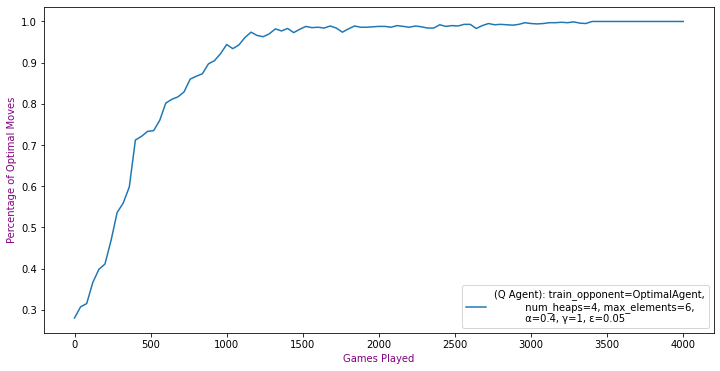

In [157]:
QAgent_v_OptimalAgent.train(4000, 4000 // 100)
QAgent_v_OptimalAgent.save_accuracy_plot()

In [158]:
QAgent_v_OptimalAgent.__dict__  # check to see values have converged nicely and nothing weird changed

{'obj_dir': 'Q Learning Agents/vs Optimal Agent',
 'train_opponent_name': 'OptimalAgent',
 'train_opponent': <__main__.OptimalAgent at 0x25f6dc4c760>,
 'num_heaps': 4,
 'max_elements': 6,
 'alpha': 0.4,
 'gamma': 1,
 'epsilon': 0.05,
 'played_games': 4000,
 'name': '(Q Agent): train_opponent=OptimalAgent,\n          num_heaps=4, max_elements=6,\n          α=0.4, γ=1, ε=0.05',
 'ascii_name': '(Q Agent) train_opponent=OptimalAgent, num_heaps=4, max_elements=6, alpha=0.4, gamma=1, epsilon=0.05',
 'Q': {(): {},
  (1,): {(0, 1): 0.9999999999999999},
  (2,): {(0, 1): 0, (0, 2): 0},
  (3,): {(0, 1): 0, (0, 2): 0, (0, 3): 0},
  (4,): {(0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0},
  (5,): {(0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (0, 5): 0},
  (6,): {(0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (0, 5): 0, (0, 6): 0},
  (1, 1): {(0, 1): -0.9999999999999999},
  (2, 1): {(0, 1): 0.9999999999999998,
   (0, 2): -0.9999999999993715,
   (1, 1): -0.9999999962868071},
  (3, 1): {(0, 1): 0, (0, 2): 0, (

In [159]:
# Training the Q Agent with itself
QAgent_v_QAgent = QLearningAgent("Q Learning Agents/vs Q Agent", 'self', 4, 6, 0.4, 1, 0.05)
QAgent_v_QAgent.__dict__  # visually check to make sure nothing looks wrong

{'obj_dir': 'Q Learning Agents/vs Q Agent',
 'train_opponent_name': 'self',
 'train_opponent': <__main__.QLearningAgent at 0x25f6dd8ac70>,
 'num_heaps': 4,
 'max_elements': 6,
 'alpha': 0.4,
 'gamma': 1,
 'epsilon': 0.05,
 'played_games': 0,
 'name': '(Q Agent): train_opponent=self,\n          num_heaps=4, max_elements=6,\n          α=0.4, γ=1, ε=0.05',
 'ascii_name': '(Q Agent) train_opponent=self, num_heaps=4, max_elements=6, alpha=0.4, gamma=1, epsilon=0.05',
 'Q': {(): {},
  (1,): {(0, 1): 0},
  (2,): {(0, 1): 0, (0, 2): 0},
  (3,): {(0, 1): 0, (0, 2): 0, (0, 3): 0},
  (4,): {(0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0},
  (5,): {(0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (0, 5): 0},
  (6,): {(0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (0, 5): 0, (0, 6): 0},
  (1, 1): {(0, 1): 0},
  (2, 1): {(0, 1): 0, (0, 2): 0, (1, 1): 0},
  (3, 1): {(0, 1): 0, (0, 2): 0, (0, 3): 0, (1, 1): 0},
  (4, 1): {(0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (1, 1): 0},
  (5, 1): {(0, 1): 0, (0, 2): 0, (0,

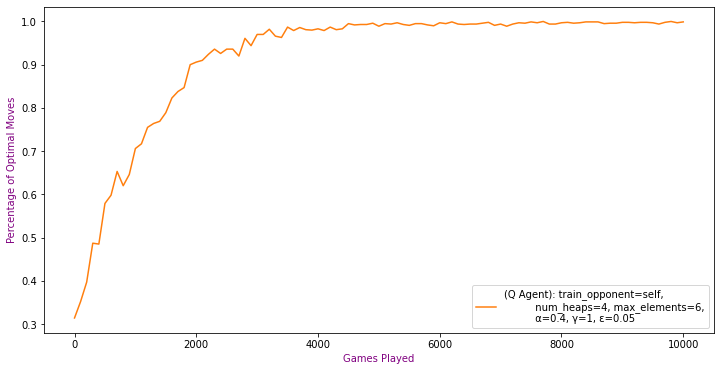

In [160]:
QAgent_v_QAgent.train(10**4, 10**4 // 100)
QAgent_v_QAgent.save_accuracy_plot(color='tab:orange')

In [161]:
QAgent_v_QAgent.__dict__  # check to see values have converged nicely and nothing weird changed

{'obj_dir': 'Q Learning Agents/vs Q Agent',
 'train_opponent_name': 'self',
 'train_opponent': <__main__.QLearningAgent at 0x25f6dd8ac70>,
 'num_heaps': 4,
 'max_elements': 6,
 'alpha': 0.4,
 'gamma': 1,
 'epsilon': 0.05,
 'played_games': 10000,
 'name': '(Q Agent): train_opponent=self,\n          num_heaps=4, max_elements=6,\n          α=0.4, γ=1, ε=0.05',
 'ascii_name': '(Q Agent) train_opponent=self, num_heaps=4, max_elements=6, alpha=0.4, gamma=1, epsilon=0.05',
 'Q': {(): {},
  (1,): {(0, 1): 0.9999999999999999},
  (2,): {(0, 1): -0.9533440000000001, (0, 2): 0.9999999999999999},
  (3,): {(0, 1): -0.4, (0, 2): -0.784, (0, 3): 0.9999999999999999},
  (4,): {(0, 1): -0.4,
   (0, 2): -0.9222400000000001,
   (0, 3): -0.784,
   (0, 4): 0.9999999999999999},
  (5,): {(0, 1): -0.4,
   (0, 2): -0.4,
   (0, 3): -0.4,
   (0, 4): -0.64,
   (0, 5): 0.9997178890092544},
  (6,): {(0, 1): -0.4,
   (0, 2): -0.4,
   (0, 3): -0.4,
   (0, 4): -0.4,
   (0, 5): -0.4,
   (0, 6): 0.4},
  (1, 1): {(0, 1): -

In [162]:
# Training the Q Agent with the Random Agent
QAgent_v_RandomAgent = QLearningAgent("Q Learning Agents/vs Random Agent", 'RandomAgent', 4, 6, 0.4, 1, 0.05)
QAgent_v_RandomAgent.__dict__  # visually check to make sure nothing looks wrong

{'obj_dir': 'Q Learning Agents/vs Random Agent',
 'train_opponent_name': 'RandomAgent',
 'train_opponent': <__main__.RandomAgent at 0x25f6e4e13a0>,
 'num_heaps': 4,
 'max_elements': 6,
 'alpha': 0.4,
 'gamma': 1,
 'epsilon': 0.05,
 'played_games': 0,
 'name': '(Q Agent): train_opponent=RandomAgent,\n          num_heaps=4, max_elements=6,\n          α=0.4, γ=1, ε=0.05',
 'ascii_name': '(Q Agent) train_opponent=RandomAgent, num_heaps=4, max_elements=6, alpha=0.4, gamma=1, epsilon=0.05',
 'Q': {(): {},
  (1,): {(0, 1): 0},
  (2,): {(0, 1): 0, (0, 2): 0},
  (3,): {(0, 1): 0, (0, 2): 0, (0, 3): 0},
  (4,): {(0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0},
  (5,): {(0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (0, 5): 0},
  (6,): {(0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (0, 5): 0, (0, 6): 0},
  (1, 1): {(0, 1): 0},
  (2, 1): {(0, 1): 0, (0, 2): 0, (1, 1): 0},
  (3, 1): {(0, 1): 0, (0, 2): 0, (0, 3): 0, (1, 1): 0},
  (4, 1): {(0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (1, 1): 0},
  (5, 1): {(0

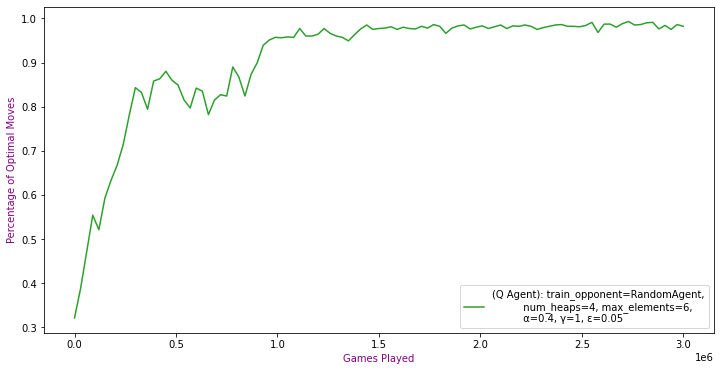

In [163]:
QAgent_v_RandomAgent.train(3*10**6, 3*10**6 // 100)
QAgent_v_RandomAgent.save_accuracy_plot(color='tab:green')

In [164]:
QAgent_v_RandomAgent.__dict__  # check to see values have converged nicely and nothing weird changed

{'obj_dir': 'Q Learning Agents/vs Random Agent',
 'train_opponent_name': 'RandomAgent',
 'train_opponent': <__main__.RandomAgent at 0x25f6e4e13a0>,
 'num_heaps': 4,
 'max_elements': 6,
 'alpha': 0.4,
 'gamma': 1,
 'epsilon': 0.05,
 'played_games': 3000000,
 'name': '(Q Agent): train_opponent=RandomAgent,\n          num_heaps=4, max_elements=6,\n          α=0.4, γ=1, ε=0.05',
 'ascii_name': '(Q Agent) train_opponent=RandomAgent, num_heaps=4, max_elements=6, alpha=0.4, gamma=1, epsilon=0.05',
 'Q': {(): {},
  (1,): {(0, 1): 0.9999999999999999},
  (2,): {(0, 1): -0.9999999999999999, (0, 2): 0.9999999999999999},
  (3,): {(0, 1): -0.35150270366794556,
   (0, 2): -0.9999999999999999,
   (0, 3): 0.9999999999999999},
  (4,): {(0, 1): 0.7614324238246032,
   (0, 2): 0.428649540369268,
   (0, 3): -0.9999999999999999,
   (0, 4): 0.9999999999999999},
  (5,): {(0, 1): 0.36535965106785695,
   (0, 2): -0.1502089551235759,
   (0, 3): 0.16611983655804985,
   (0, 4): -0.9999999999999999,
   (0, 5): 0.999

In [165]:
def plot_multiple_accuracy(agents : List[Agent], title: str = None, scale: float = None) -> None:
    """
    **Description:**
        - Plots the accuracies of multiple agents in one plot
    """

    dataframes = [agent.accuracy for agent in agents]

    fig = dataframes[0].plot()
    for i in range(1, len(dataframes)):
        dataframes[i].plot(ax=fig)
    plt.xlabel(dataframes[0].index.name, color = "purple")
    plt.ylabel("Percentage of Optimal Moves", color = "purple")

    if scale:
        lxlim, rxlim = plt.xlim()
        plt.xlim(lxlim * scale, rxlim * scale)
    if title:
        plt.title(title, color = "purple")


def save_multiple_accuracy_plots(agents : List[Agent], title: str = None, scale: float = None) -> None:
    """
    **Description:**
        - Plots the accuracies of multiple agents in one plot and saves it

    """

    plot_multiple_accuracy(agents, title, scale)
    plt.savefig("Q Learning Agents/Joined Plots/" + title + ".png")

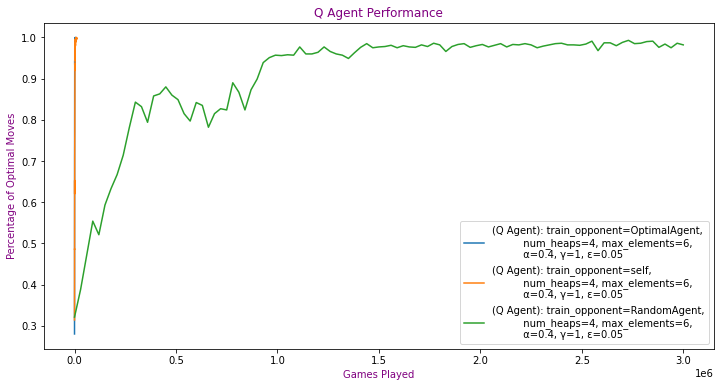

In [166]:
save_multiple_accuracy_plots([QAgent_v_OptimalAgent, QAgent_v_QAgent, QAgent_v_RandomAgent], "Q Agent Performance")

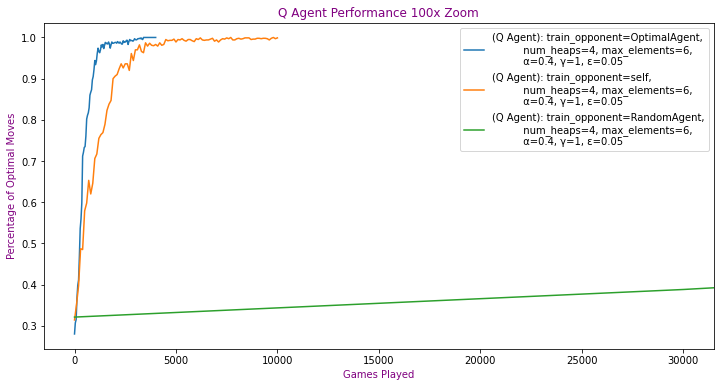

In [167]:
save_multiple_accuracy_plots([QAgent_v_OptimalAgent, QAgent_v_QAgent, QAgent_v_RandomAgent], "Q Agent Performance 100x Zoom", scale=1/100)